En aquesta pràctica treballareu amb un model de detecció d’objectes basat en PyTorch i la xarxa neuronal VGG16. L'objectiu es modificar el model per adaptar-lo a un problema de detecció d'objectes específic utilitzant un conjunt de dades simples.

![Exemple](08_Detecció/imgs/img.png)

Emprarem un *dataset* de detecció d'objectes que conté imatges d'estrelles. Aquest conjunt de dades és senzill i ideal per a practicar tècniques de detecció d'objectes. El podeu trobar a Kaggle al següent [enllaç](https://www.kaggle.com/datasets/kishanj/simple-object-detection). Per carregar aquest tipus de dataset haurem d'implementar una classe personalitzada que hereti de `torch.utils.data.Dataset`.

In [1]:
import os
import copy
import random
import xml.etree.ElementTree as ET

from PIL import Image
import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import Adam, lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torchvision import models, transforms

import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [4]:
class EstrellesDataset(Dataset):
    def __init__(self, img_dir, ann_dir, classes=None, transform=None):
        super().__init__()
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.classes = classes
        self.transform = transform

        self.image_files = sorted([
            f for f in os.listdir(img_dir)
            if f.lower().endswith((".jpg", ".jpeg", ".png"))
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_filename = self.image_files[idx]
        img_path = os.path.join(self.img_dir, img_filename)
        img = Image.open(img_path).convert("RGB")

        ann_filename = os.path.splitext(img_filename)[0] + ".xml"
        ann_path = os.path.join(self.ann_dir, ann_filename)

        bbox, label = self._parse_annotation(ann_path)

        if self.transform:
            img = self.transform(img)

        bbox = torch.tensor(bbox, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        return img, label, bbox

    def _parse_annotation(self, xml_path):
        tree = ET.parse(xml_path)
        root = tree.getroot()

        obj = root.find("object")
        label_name = obj.find("name").text

        label_idx = 1 if label_name.lower() == "star" else 0

        bndbox = obj.find("bndbox")
        xmin = int(bndbox.find("xmin").text)
        ymin = int(bndbox.find("ymin").text)
        xmax = int(bndbox.find("xmax").text)
        ymax = int(bndbox.find("ymax").text)

        bbox = [xmin, ymin, xmax, ymax]

        return bbox, label_idx


In [ ]:
BATCH = 8
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CLASSES = ["star"]

imagenet_mean = [0.48235, 0.45882, 0.40784]
imagenet_std  = [0.00392156862745098, 0.00392156862745098, 0.00392156862745098]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

dataset = EstrellesDataset(
    img_dir="datasets/images",
    ann_dir="datasets/annotations",
    classes=CLASSES,
    transform=transform
)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size


train_dataset, val_dataset = random_split(dataset, [train_size, val_size], torch.Generator().manual_seed(123))

train_loader = DataLoader(train_dataset, batch_size = BATCH, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size = BATCH, shuffle=False)

image = Image.open("mini_txuxi\mini\train\mask\00480.png")
image = np.array(image)*255

In [6]:
def show_sample(img, bbox, label=None, classes=None):
    if isinstance(img, torch.Tensor):
        img = img.permute(1, 2, 0).numpy()

    fig, ax = plt.subplots(1, figsize=(6, 6))
    ax.imshow(img)

    x_min, y_min, x_max, y_max = bbox
    rect = patches.Rectangle(
        (x_min, y_min),
        x_max - x_min,
        y_max - y_min,
        linewidth=2,
        edgecolor='red',
        facecolor='none'
    )
    ax.add_patch(rect)

    if label is not None:
        if classes and isinstance(label, torch.Tensor):
            label = classes[label.item()]
        ax.text(x_min, y_min - 5, str(label), color='red',
                fontsize=12, backgroundcolor='white')

    plt.axis("off")
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-122.99924..151.0008].


Shapes dels Batches:
Imgs: torch.Size([8, 3, 224, 224])
Labels: torch.Size([8])
BBoxes: torch.Size([8, 4])


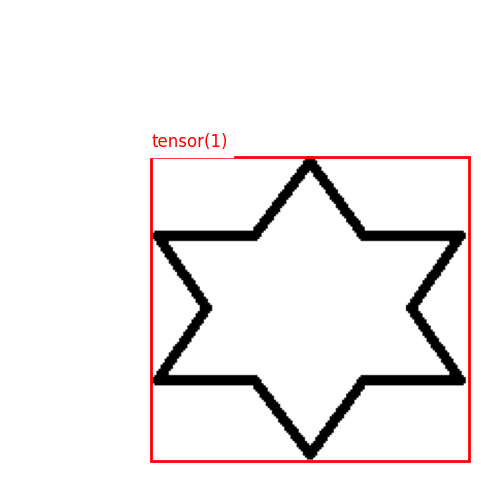

In [5]:
imgs, labels, bboxes = next(iter(train_loader))

print("Shapes dels Batches:")
print("Imgs:", imgs.shape)
print("Labels:", labels.shape)
print("BBoxes:", bboxes.shape)

show_sample(imgs[0], bboxes[0], labels[0])


## Preparació del model

Començarem carregant el model VGG16 preentrenat i adaptant-lo per a la detecció d'objectes. Afegirem capes addicionals per predir les caixes delimitadores (bounding boxes) i les classes dels objectes.

In [7]:
vgg16 = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
backbone = vgg16.features

class VGG16ObjectDetector(nn.Module):
    def __init__(self, backbone, num_classes):
        super().__init__()
        self.backbone = backbone
        self.avgpool = vgg16.avgpool

        # Capes fully-connected de la VGG original
        self.flatten = nn.Flatten()

        self.fc = nn.Sequential(*list(vgg16.classifier.children())[:-1])

        # Cap de classificació
        self.class_head = nn.Linear(4096, num_classes)

        # Cap de regressió de bounding box
        self.bbox_head = nn.Linear(4096, 4)

    def forward(self, x):
        x = self.backbone(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        x = self.fc(x)

        return self.class_head(x), self.bbox_head(x)

model = VGG16ObjectDetector(backbone=backbone, num_classes = len(CLASSES))
print(model)

VGG16ObjectDetector(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, paddi

In [7]:
# Provam per veure que les dimension i batch works
x = torch.randn(1, 3, 224, 224)
class_logits, bbox_preds = model(x)
print(class_logits.shape, bbox_preds.shape)
print(class_logits)
print(bbox_preds)

torch.Size([1, 1]) torch.Size([1, 4])
tensor([[-0.1569]], grad_fn=<AddmmBackward0>)
tensor([[-0.1992,  0.0904, -0.1351,  0.0004]], grad_fn=<AddmmBackward0>)


In [ ]:
# Binary Class, ergo, BCE
cls_loss_fn = nn.BCEWithLogitsLoss()
# Emprar L1 Loss MAE: https://docs.pytorch.org/docs/stable/generated/torch.nn.L1Loss.html
# La emprarem juntament amb una custom per el loss fn de BBox
bbox_loss_fn = nn.SmoothL1Loss()

# Igual que a la darrera pràctica provam amb un finetune amb differents optimitzadors per regions
optimizer = Adam([
    {"params": model.backbone.parameters(), "lr": 1e-5},
    {"params": model.fc.parameters(), "lr": 1e-4},
    {"params": model.class_head.parameters(), "lr": 1e-4},
    {"params": model.bbox_head.parameters(), "lr": 5e-5},
])
'''
Tenim dues tasques, classificació i regressió de bounding box, per tant
podem definir diferents learning rates per a diferents parts del model.

Concretament, la classificació en aquest cas es binària, hia ha estrella o no (object - not object),

En quant a la regressió del bounding box, feim us de dues funcions:
L1: 
    - Penalitza error a nivell de coordenada.
    - Creix linealment per errors grans, quadratic per a petits.
    - Sensible a la escala.
GIoU:
    - Penalització de sobreposició entre bbox predita i gt.
    - Quan la predicció es 100% igual bbox_real = bbox_pred, idò loss=0
    - "     "       "   "   0% igual bbox_real no intersecta amb bbox_pred loss>=1

Les unim per dur a terme una millora respecte les coordenades, overlap i fit de la figura.

En quant als differents LR:
1. backbone: Es un fine tune del backbone heretat per f.e
2. fc: Mes adaptiu i important ja que unim backbone amb els caps
3. class_head: LR mes alt ja que hem d'aprendre mes
4. bbox: Regressió sol tenir una variablitat més alta (més renou),
        volem un LR més baix per minimitzar instabilitat. 

LOSS de BBOX: pix val.
'''

# Scheduler LR on plateau per reduir el lr quan arribam a un plato i veure si podem millorar encara mes
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

# Previous sched però vamos que no funciona muy bine
# scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

model = model.to(DEVICE)

# Shall not explain pero ens diu es loss between dos areas
# Molt interessant: https://giou.stanford.edu/
def giou_loss(pred_boxes, true_boxes):
    x1 = torch.max(pred_boxes[:, 0], true_boxes[:, 0])
    y1 = torch.max(pred_boxes[:, 1], true_boxes[:, 1])
    x2 = torch.min(pred_boxes[:, 2], true_boxes[:, 2])
    y2 = torch.min(pred_boxes[:, 3], true_boxes[:, 3])

    inter = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    area_pred = (pred_boxes[:, 2] - pred_boxes[:, 0]) * (pred_boxes[:, 3] - pred_boxes[:, 1])
    area_true = (true_boxes[:, 2] - true_boxes[:, 0]) * (true_boxes[:, 3] - true_boxes[:, 1])
    union = area_pred + area_true - inter + 1e-6
    iou = inter / union

    cx1 = torch.min(pred_boxes[:, 0], true_boxes[:, 0])
    cy1 = torch.min(pred_boxes[:, 1], true_boxes[:, 1])
    cx2 = torch.max(pred_boxes[:, 2], true_boxes[:, 2])
    cy2 = torch.max(pred_boxes[:, 3], true_boxes[:, 3])
    area_c = (cx2 - cx1) * (cy2 - cy1) + 1e-6

    giou = iou - (area_c - union) / area_c
    return (1 - giou).mean()

# Nothing new
def train_epoch(model, loader):
    model.train()
    total_cls_loss, total_bbox_loss = 0, 0

    for images, labels, boxes in loader:
        images = images.to(DEVICE)
        labels = labels.float().to(DEVICE).view(-1, 1)
        boxes = boxes.float().to(DEVICE)

        optimizer.zero_grad()
        class_logits, bbox_preds = model(images)

        cls_loss = cls_loss_fn(class_logits, labels) # <- BCE
        bbox_loss = 0.5 * bbox_loss_fn(bbox_preds, boxes) + 0.5 * giou_loss(bbox_preds, boxes) # <- Ponderam entre L1 i giou_loss 
        loss = 0.1*cls_loss + bbox_loss # <- 0.1 not necessary TODO maybe worth looking at alpha * cls_loss + beta * bbox_loss amb valors tuned

        loss.backward()
        optimizer.step()

        total_cls_loss += cls_loss.item()
        total_bbox_loss += bbox_loss.item()

    print(f"Train -> BCE: {total_cls_loss/len(loader):.4f} | "
          f"BBox: {total_bbox_loss/len(loader):.4f}")
    return total_cls_loss/len(loader), total_bbox_loss/len(loader)


def validate(model, loader):
    model.eval()
    total_cls_loss, total_bbox_loss = 0, 0

    with torch.no_grad():
        for images, labels, boxes in loader:
            images = images.to(DEVICE)
            labels = labels.float().to(DEVICE).view(-1, 1)
            boxes = boxes.float().to(DEVICE)

            class_logits, bbox_preds = model(images)

            cls_loss = cls_loss_fn(class_logits, labels)
            bbox_loss = bbox_loss_fn(bbox_preds, boxes)

            total_cls_loss += cls_loss.item()
            total_bbox_loss += bbox_loss.item()

    print(f"Val -> BCE: {total_cls_loss/len(loader):.4f} | "
          f"BBox: {total_bbox_loss/len(loader):.4f}")
    return total_cls_loss/len(loader), total_bbox_loss/len(loader)


In [9]:
EPOCHS = 50
best_model_wts = copy.deepcopy(model.state_dict())
best_val_loss = float("inf")
patience = 20
counter = 0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    
    train_cls_loss, train_bbox_loss = train_epoch(model, train_loader)
    val_cls_loss, val_bbox_loss = validate(model, val_loader)
    val_total_loss = val_cls_loss + val_bbox_loss
    scheduler.step(val_total_loss)

    # Aqui es un mechanisme per intenar explorar millora continua mentre sigamos millorant
    # patience = steps before I break the sim
    if val_total_loss < best_val_loss:
        best_val_loss = val_total_loss
        best_model_wts = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), "best_model.pth")
        print(f"New best val loss: {best_val_loss:.4f} — model saved.")
        counter = 0
    else:
        counter += 1
        print(f"No improvement ({counter}/{patience})")

    if counter >= patience:
        print("Early stopping triggered.")
        break

model.load_state_dict(best_model_wts)
print(f"\nBest validation total loss: {best_val_loss:.4f}")



Epoch 1/50
Train -> BCE: 0.6207 | BBox: 29.6702
Val -> BCE: 0.0000 | BBox: 23.2367
New best val loss: 23.2367 — model saved.

Epoch 2/50
Train -> BCE: 0.0000 | BBox: 13.2464
Val -> BCE: 0.0000 | BBox: 18.9025
New best val loss: 18.9025 — model saved.

Epoch 3/50
Train -> BCE: 0.0001 | BBox: 10.4541
Val -> BCE: 0.0000 | BBox: 11.9995
New best val loss: 11.9995 — model saved.

Epoch 4/50
Train -> BCE: 0.0000 | BBox: 10.0125
Val -> BCE: 0.0000 | BBox: 11.4027
New best val loss: 11.4027 — model saved.

Epoch 5/50
Train -> BCE: 0.0002 | BBox: 10.5179
Val -> BCE: 0.0000 | BBox: 13.6248
No improvement (1/20)

Epoch 6/50
Train -> BCE: 0.0000 | BBox: 10.3873
Val -> BCE: 0.0000 | BBox: 10.7545
New best val loss: 10.7545 — model saved.

Epoch 7/50
Train -> BCE: 0.0000 | BBox: 8.8619
Val -> BCE: 0.0000 | BBox: 11.3360
No improvement (1/20)

Epoch 8/50
Train -> BCE: 0.0001 | BBox: 8.1745
Val -> BCE: 0.0000 | BBox: 10.1833
New best val loss: 10.1833 — model saved.

Epoch 9/50
Train -> BCE: 0.0000 |

## Reload model and test

In [8]:
model = VGG16ObjectDetector(backbone, num_classes=len(CLASSES))
model.load_state_dict(torch.load("best_model.pth", map_location=DEVICE))
model = model.to(DEVICE)
model.eval()

VGG16ObjectDetector(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, paddi

## Plotting and testing

In [9]:
def draw_boxes(ax, bbox, label=None, color="lime", label_prefix=""):
    x_min, y_min, x_max, y_max = bbox
    width, height = x_max - x_min, y_max - y_min
    rect = patches.Rectangle(
        (x_min, y_min), width, height,
        linewidth=2, edgecolor=color, facecolor="none"
    )
    ax.add_patch(rect)
    if label is not None:
        ax.text(
            x_min, y_min - 5,
            f"{label_prefix}{label}",
            color=color,
            fontsize=8,
            backgroundcolor="black"
        )


In [10]:
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
import torchvision.transforms.functional as F
from PIL import ImageDraw, ImageFont


def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406], device=img_tensor.device).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=img_tensor.device).view(3, 1, 1)
    return (img_tensor * std + mean).clamp(0, 1)


def adjust_label_positions(boxes):
    positions = []
    used_positions = []

    for b in boxes:
        x = int(b[0])
        y = int(b[1])

        while any(abs(y - uy) < 16 for (_, uy) in used_positions):
            y += 16

        positions.append((x, y))
        used_positions.append((x, y))

    return positions


def compute_iou(box1, box2):
    xA, yA = max(box1[0], box2[0]), max(box1[1], box2[1])
    xB, yB = min(box1[2], box2[2]), min(box1[3], box2[3])
    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (box1[2] - box1[0]) * (box1[3] - box1[1])
    boxBArea = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = boxAArea + boxBArea - interArea + 1e-6
    return interArea / union


def fix_box_order(box):
    x1, y1, x2, y2 = box
    return [min(x1, x2), min(y1, y2), max(x1, x2), max(y1, y2)]


def visualize_predictions(model, dataset, num_images=25, img_size=224):
    model.eval()
    num_images = min(num_images, len(dataset))
    indices = random.sample(range(len(dataset)), num_images)

    cols = int(np.ceil(np.sqrt(num_images)))
    rows = int(np.ceil(num_images / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(3.5 * cols, 3.5 * rows))
    axes = axes.flatten()

    for ax, idx in zip(axes, indices):
        img, gt_label, gt_bbox = dataset[idx]
        img_tensor = img.unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            pred_logits, pred_bbox = model(img_tensor)
            pred_prob = torch.sigmoid(pred_logits).item()
            pred_label = "Star" if pred_prob > 0.5 else "None"
            pred_bbox = pred_bbox.squeeze(0).cpu().numpy()

        pred_bbox = fix_box_order(np.clip(pred_bbox, 0, img_size))
        gt_bbox = fix_box_order(gt_bbox.tolist())

        iou = compute_iou(gt_bbox, pred_bbox)

        gt_text = f"GT: {'Star' if gt_label.item() == 1 else 'None'}"
        pred_text = f"Pred: {pred_label} ({pred_prob:.2f}) | IoU={iou:.2f}"

        img_denorm = denormalize(img).cpu()
        img_uint8 = (img_denorm * 255).to(torch.uint8)

        boxes = torch.tensor([gt_bbox, pred_bbox], dtype=torch.float32).round().to(torch.int)
        labels = [gt_text, pred_text]
        colors = ["#00FF88", "#FF4444"]

        
        drawn = draw_bounding_boxes(img_uint8, boxes=boxes, colors=colors, width=2)

        
        pil_img = to_pil_image(drawn)
        draw = ImageDraw.Draw(pil_img)

        try:
            font = ImageFont.truetype("arial.ttf", 12)
        except:
            font = ImageFont.load_default()


        label_positions = adjust_label_positions(boxes)

        for i, (text, (x, y)) in enumerate(zip(labels, label_positions)):
            
            bbox = draw.textbbox((0, 0), text, font=font)
            text_w = bbox[2] - bbox[0]
            text_h = bbox[3] - bbox[1]

            
            draw.rectangle(
                [x, y, x + text_w + 4, y + text_h + 2],
                fill="black"
            )
            
            draw.text(
                (x + 2, y + 1),
                text,
                fill=colors[i],
                font=font
            )

        drawn = F.pil_to_tensor(pil_img)

        ax.imshow(to_pil_image(drawn))
        ax.axis("off")

    
    for ax in axes[num_images:]:
        ax.axis("off")

    plt.subplots_adjust(wspace=0.05, hspace=0.1, top=0.92)
    plt.suptitle("Ground Truth (green) vs Predicted (red)", fontsize=16, weight="bold", y=0.98)
    plt.show()


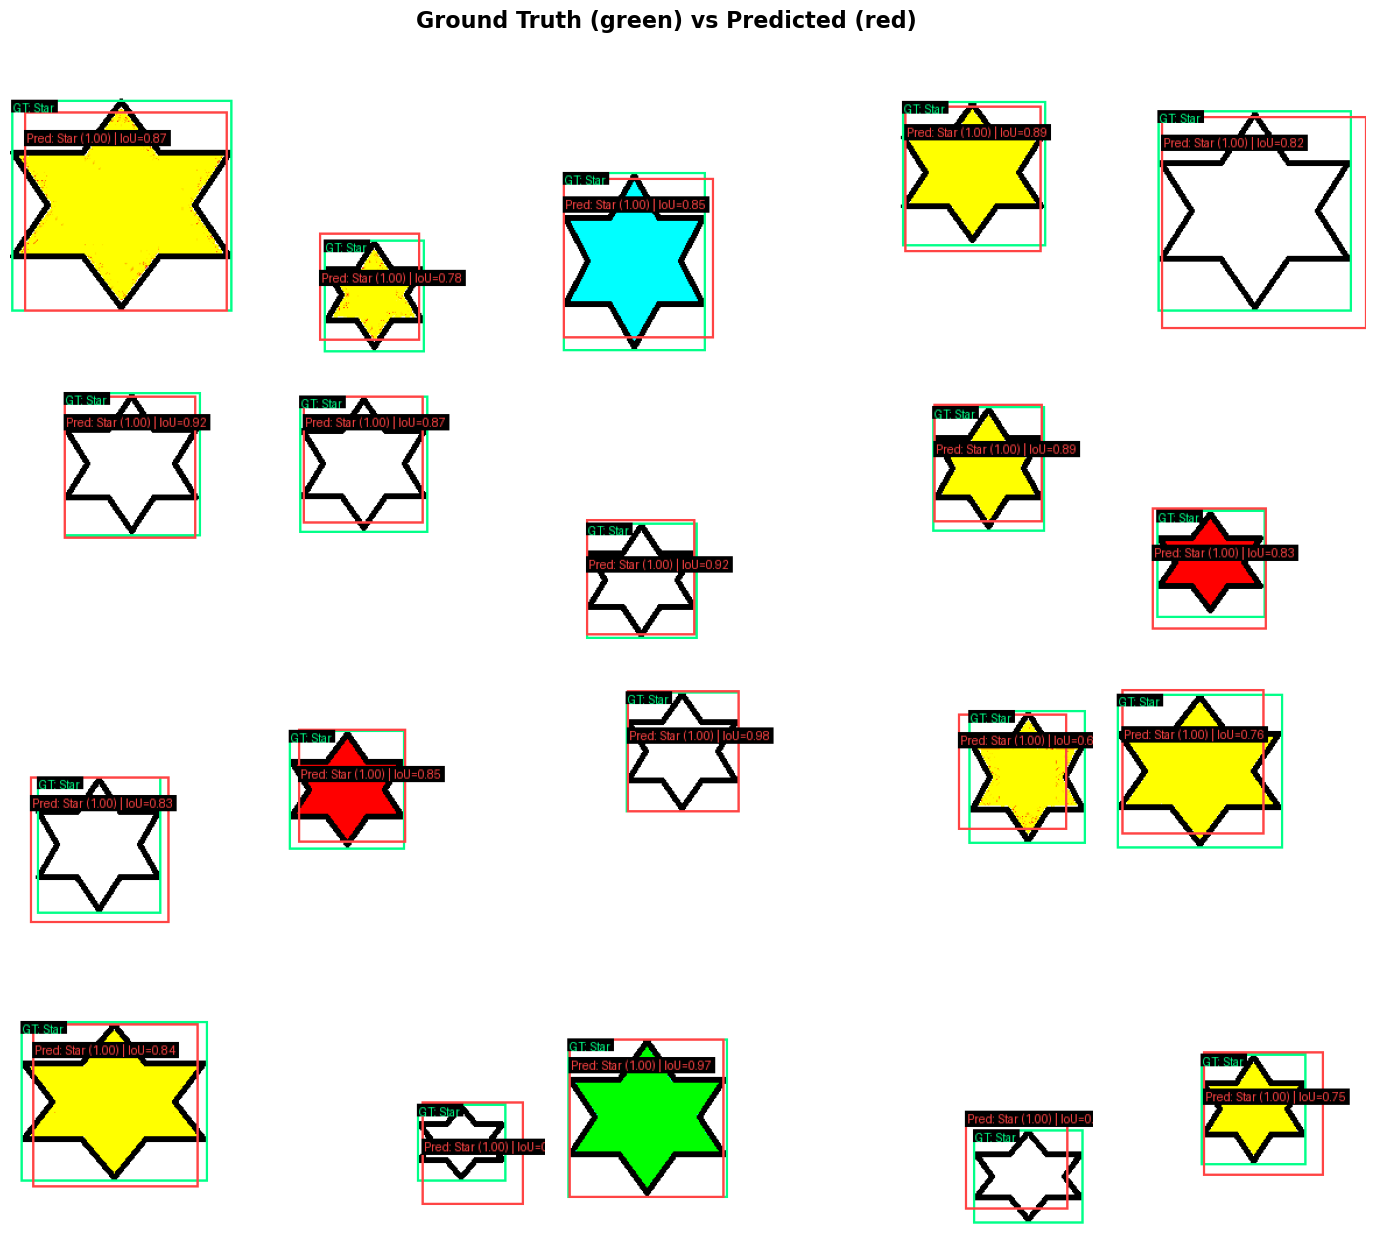

In [97]:
visualize_predictions(model, val_dataset, num_images=20)
